# 证券列表、板块和K线数据

欢迎来到大富翁量化教程第一章。在这一章里，我们将学习如何获取市场证券列表和概念板块，以及获取某一支证券的K线数据。在文章最后部分，我们还将介绍一个有一定实用价值的交易策略。

这些功能是编写交易系统的起点。如果您想要制定一个覆盖全市场的交易策略，您就需要知道如何获取所有的证券列表，并且一一获取它们的k线数据，进行运算，最后发出交易信号。

此外，如果您觉得最近有值得关注的概念板块，您也可能只想关注这些概念板块里的证券品种，这是一种手工化的、但行之有效的优化。

## 初始化Omicron

In [95]:
from IPython.display import clear_output
from omicron.core.types import FrameType
from omicron.core.timeframe import tf
import cfg4py
from omega.config import get_config_dir

cfg4py.init(get_config_dir())
import omicron
await omicron.init()
clear_output()

首先，这段代码引入了omicron这个核心库。Omicron主要负责数据的读写，基础量化因子的计算，还提供了大富翁中的一些核心类型的定义，比如帧类型(FrameType)，时间帧的相关计算(timeframe)等等。

这里还出现了[cfg4py](https://pypi.org/project/cfg4py/)。Cfg4Py是一个非常好用的配置管理工具，提供了配置热更新、代码提示和自动完成、环境变量替换、多部署环境自适应、层级式配置管理(cascading)、配置模版等功能。

Zillionare使用了Cfg4Py来管理配置。上面的第6行中，我们先对配置模块进行初始化。这让Omicron可以知道数据库和缓存的连接信息。关于这部分是如何工作的，请参见[TODO://diveintozillionare/configure](404.md)。如果您是使用我们提供的docker运行环境，那么您完全不用在意这些配置信息。只需要知道要使用Omicron，必须先进行配置初始化就可以了。

然后我们通过`omicron.init()`来对omicron进行初始化。初始化完成以后，证券列表就加载到程序中，数据库、缓存的连接也就都建立好了。

??? Tips
    注意大富翁里很多函数都是异步的，您需要通过`await`关键字来进行调用 。

## 证券列表
现在，让我们看看都有哪些证券品种。

In [96]:
import pandas as pd
secs = await omicron.models.securities.get_security_list()
pd.DataFrame(data=secs[:5])

,0,1,2,3,4,5
0,000001.XSHE,平安银行,PAYH,1991-04-03,2200-01-01,stock
1,000001.XSHG,上证指数,SZZS,1991-07-15,2200-01-01,index
2,000002.XSHE,万科A,WKA,1991-01-29,2200-01-01,stock
3,000002.XSHG,A股指数,AGZS,1992-02-21,2200-01-01,index
4,000003.XSHG,B股指数,BGZS,1992-02-21,2200-01-01,index


返回值包括证券代码（如000001.XSHG）,证券名称（如平安银行，上证指数等），证券简码(如PAYX)，该证券的上市交易日，终止上市时间，以及证券类型。

最后一栏是证券类型。大富翁支持的证券类型主要有股票(stock)，指数(index),对于ETF基金(etf),此外还有分级(fja,fjb,fjm），场内交易货币基金和其它基金。目前大富翁只接入了聚宽一家数据源，聚宽是支持这些类型的，所以大富翁当下也因此支持这些类型定义。不过，这部分定义未来可能会有所更改。但是，对于`stock`和`index`的定义，会一直保持不变。

这里提示一下关于上市交易日和终止上市时间的使用。在做短线交易时，我们并不需要获取那些已退市证券的数据，这时就要使用终止上市时间来进行过滤。有时候为了获取足够长的数据来进行演算，我们也需要使用上市交易日来过滤掉一些刚上市不久、数据还不够充分的数据。

证券代码在不同的行情软件中，表示方法并不一致。上交所和深交所原始数据中，并没有上述代码中的".XSHG"这样的后缀，因此，000001这样的代码在不同的市场上可能都存在，只是含义不同。比如000001在上交所这边代表上证指数，而在深交所则代表平安银行。如果你拿到的是这样的数据，则需要先进行转码处理。在大富翁的数据中，我们使用了带交易所编号的全码，这样处理是比较恰当的。每个证交所都会保证自己的编码系统的惟一性，因此这个全码就惟一标识了一支证券品种。

上面的代码中引入了pandas这个库。这里并不是必须的，我们在这里引用它，只是通过它可以使得输出更整洁美观一点。

`omicron.models.securities.get_security_list()`返回的数据类型是numpy数组。在zillionare中，更广泛使用的数据结构是numpy的structured array，与dataframe相比，它在易用性、性能和内存占用上，都更加有优势。当然，这个对比仅限于行情数据处理这个场景。在其它场景下，也可能dataframe更有优势。

我们常常通过Securities这个类来操作证券列表，而不是直接使用`get_security_list`这个接口。

In [97]:
from omicron.models.securities import Securities

secs = Securities()
secs.choose(['index'])[:3]

['000001.XSHG', '000002.XSHG', '000003.XSHG']

通过上面的代码，我们从全市场中选择了指数型标的。

现在，让我们来看看如何以更简单的方式来访问证券的基本属性：

In [98]:
from omicron.models.security import Security

sec = Security('000001.XSHE')

# 显示证券代码、名称、IPO日期，终止上市日期，拼音简称
print(sec.code, sec.display_name, sec.ipo_date, sec.end_date, sec.name)

000001.XSHE 平安银行 1991-04-03 2200-01-01 PAYH


如果我们需要判断一支证券标的是否为次新股，那么可以通过`sec.days_since_ipo`来得到其信息：

In [99]:
sec.days_since_ipo()

3944


## 概念分类

除了上述基本属性外，证券（股票）还会有自己的行业属性、地域属性（总部或者注册地），概念（题材）等属性。除此之外，象通达信软件，还会给每支股票打上风格属性，比如"新股"、"近期强势"、"超跌"等。

???+ Tips
    在A股，市场炒作气氛浓郁时，会发生炒地图（比如自贸区、成渝规划）、炒概念（比如2020年的免税、地摊）、炒行业（比如2020年下半年的炒作的光伏既是题材概念、也是行业景气概念。光伏景气是一个行业全产业链的景气）。对短线炒题材的选手来说，如何蹭到具有多个概念的股票，是很重要的选股策略。

    大富翁在1.0中并未提供这些概念分类，因为我们的目标是为量化交易提供高性能的计算平台，基于优选级考虑，对性能要求不高，其它工具已经有的功能，就可能放在后面的版本来实现。但是，由于大富翁集成了jqdatasdk,jqdatasdk的这些功能，对您来说也是完全开箱即用的。

这里我们以如何找出同时具有多个概念的个股为例，来讲解聚宽相关的API。

假设我们要获取具有"智能电网"、"物联网”概念属性的深圳本地股：

In [100]:
# 获取地域。这里要使用finance中的查询
import os
import jqdatasdk as jq

account = os.environ['JQ_ACCOUNT']
password = os.environ['JQ_PASSWORD']
jq.auth(account, password)

首先，我们要引入jqdatasdk这个库，并且完成登录。

完成登录需要提供您在聚宽平台上面注册的账号和密码。我们这里使用的方法是，通过环境变量设置您的聚宽账号和密码，然后通过`os.environ`来获取它们。这是一种出于安全考虑的技巧：即使您分享了您的策略，也不会意外泄露您的账号和密码。

In [101]:
from jqdatasdk import finance
from jqdatasdk import query

# 通过jqdatasdk获取证券列表
securities = jq.get_all_securities()
code = '000001.XSHE'
rec = finance.run_query(query(finance.STK_COMPANY_INFO).filter(finance.STK_COMPANY_INFO.code==code).limit(1))

#我们使用下面的函数，将前面获得的securities对象加上两列，即province和city
def add_region_info(securities):
    company_infos = finance.run_query(query(finance.STK_COMPANY_INFO))
    for code in securities.index:
        rec = company_infos[company_infos['code'] == code]
        if len(rec) == 0:
            securities.loc[code, 'province'] = None
            securities.loc[code, 'city'] = None
        else:
            securities.loc[code, 'province'] = rec['province'].iat[0]
            securities.loc[code, 'city'] = rec['city'].iat[0]
add_region_info(securities)
securities[:3]

,display_name,name,start_date,end_date,type,province,city
000001.XSHE,平安银行,PAYH,1991-04-03,2200-01-01,stock,广东,深圳市
000002.XSHE,万科A,WKA,1991-01-29,2200-01-01,stock,广东,深圳市
000004.XSHE,国华网安,GHWA,1990-12-01,2200-01-01,stock,广东,深圳市


可以看到，与前面的输出信息相比，这里的输出多了公司所在地省市的信息。下面我们看看如何获取概念板块：

In [102]:
# 获取概念板块
concepts = jq.get_concepts()

def query_stock_by_concept(query_concepts, province=None, city=None):
    stocks = set()
    for name in query_concepts:
        concept = concepts[concepts['name'] == name]
        if len(concept) == 0:
            continue
            
        idx = concept.index[0]
        members = set(jq.get_concept_stocks(idx))
        if len(stocks) == 0:
            stocks = members
        else:
            stocks = stocks.intersection(members)
         
    results = []

    for code in stocks:
        if province and securities.loc[code, 'province'] != province:
            continue
        if city and securities.loc[code, 'city'] != city:
            continue
            
        results.append(code)
        
    return results
        
#jq.get_concept_stocks('GN001')
stocks = query_stock_by_concept(['智能电网','物联网'],'广东','深圳市')
print(stocks)

['300514.XSHE', '300044.XSHE']


经过查询，我们得到两只股票，300044.XSHE和300514.XSHE。如果我们通过这两个代码来构造Security对象，就可以得到它们的名字：

In [103]:
print(Security('300044.XSHE').display_name)

赛为智能


好了！我们知道在A股题材炒作行情阶段，如果一个品种具有多个题材（概念），则更容易成为资金追逐的对象。现在，有了上面的方法，您也可以很轻松地寻找到同时具有多个热点概念的股票了！

## 获取行情数据

接下来，让我们看看如何获取行情数据：

In [104]:
import datetime

sec = Security("000001.XSHE")
start = datetime.date(2020, 12, 1)
end = datetime.date(2020, 12, 5)
await sec.load_bars(start, end, FrameType.DAY)

array([(datetime.date(2020, 12, 1), 19.7 , 20.51, 19.4 , 20.05, 1.26371975e+08, 2.51601078e+09, 120.77),
       (datetime.date(2020, 12, 2), 19.93, 20.06, 19.52, 19.63, 8.89385290e+07, 1.75863919e+09, 120.77),
       (datetime.date(2020, 12, 3), 19.78, 19.86, 19.17, 19.54, 7.14452300e+07, 1.39308502e+09, 120.77),
       (datetime.date(2020, 12, 4), 19.47, 19.47, 18.97, 19.3 , 8.91347840e+07, 1.70763907e+09, 120.77)],
      dtype=[('frame', 'O'), ('open', '<f4'), ('high', '<f4'), ('low', '<f4'), ('close', '<f4'), ('volume', '<f8'), ('amount', '<f8'), ('factor', '<f4')])

所以，要获取行情数据，您只需要先构造对应的Security对象，通过`load_bars`函数，并传入行情起始时间、结束时间和k线种类就可以了。

这里加载的行情数据，关于量能方面，是通过volume和amount来表示的，分别对应着成交量（手数）和成交额（金额，单位元）。很多时候我们更希望使用换手率的概念，特别是当我们需要在各个品种之间横向比较的时候。

要获取换手率，需要给`load_bars`传入`turnover`参数：

In [105]:
await sec.load_bars(start, end, FrameType.DAY, turnover=True, fq=True)

rec.array([(datetime.date(2020, 12, 1), 19.7 , 20.51, 19.4 , 20.05, 1.26371975e+08, 2.51601078e+09, 120.77, 0.6512088 ),
           (datetime.date(2020, 12, 2), 19.93, 20.06, 19.52, 19.63, 8.89385290e+07, 1.75863919e+09, 120.77, 0.45831013),
           (datetime.date(2020, 12, 3), 19.78, 19.86, 19.17, 19.54, 7.14452300e+07, 1.39308502e+09, 120.77, 0.36816522),
           (datetime.date(2020, 12, 4), 19.47, 19.47, 18.97, 19.3 , 8.91347840e+07, 1.70763907e+09, 120.77, 0.45932144)],
          dtype=[('frame', 'O'), ('open', '<f4'), ('high', '<f4'), ('low', '<f4'), ('close', '<f4'), ('volume', '<f8'), ('amount', '<f8'), ('factor', '<f4'), ('turnover', '<f4')])

??? Tips
    在大富翁中，k线数据默认使用前复权。您也可以通过`fq=False`来调用`load_bars`,获取不复权的数据。大富翁不提供后复权数据，但数据包含了复权因子，您可以自行计算。

现在，让我们用get_bars来做一点实际的工作。我们来画一条平吉林森工今天（2020年10月13日）的分时线。

???+ Tips
    注意分时线的均线有两种算法。
    
    我们对个股是用截止当前的累计成交额（使用numpy的cumsum函数），除以截止当前的累计成交量来求得的。它对波动起到有效地平滑作用，而且成交量越小的价格，在最终均价中占的权重也越小，从而滤掉了**做骗线的杂波**。
    
    对于指数，上述方法似乎不对，可能跟指数编制方法有关，所以这里使用的是截止当前时刻的指数平均。
    
    在短线交易中，一定要重视量的作用。在成交不活跃的时候，有时候很少几手交易，就能引起股价比较大的波动，但是，它们并不能代表资金都股价的看法。如果把股价看成资金对价格的表决的话，最终一定是多数资金的投票才会生效。

In [106]:
import arrow # arrow是一个时间处理库
end = arrow.get('2020-10-13 15:00:00', tzinfo='Asia/Shanghai')
start = tf.shift(end, -240, FrameType.MIN1)

bars_jlsg = await Security('600189.XSHG').load_bars(start, end, FrameType.MIN1)
bars_sh = await Security('000001.XSHG').load_bars(start, end, FrameType.MIN1)

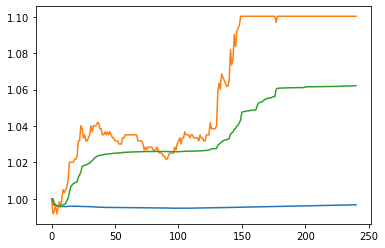

In [107]:
import matplotlib.pyplot as plt # matplotlib是常用的绘图库
import numpy as np

# 大盘走势,为便于比较，使用了涨跌幅

plt.plot((np.cumsum(bars_sh['close'])/np.cumsum(bars_sh['close']>0))/bars_sh['open'][0])
# 吉林森工的股价变化
plt.plot(bars_jlsg['close']/bars_jlsg['close'][0])
# 吉林森工的均价线
plt.plot((np.cumsum(bars_jlsg['amount'])/np.cumsum(bars_jlsg['volume']))/bars_jlsg['open'][0])

上图中，黄色的线是个股的收盘分时线，绿色线是其均价线，蓝色线是大盘均价线。关于如何绘图，我们放在第二章讲。

为了便于比较，我们将两个品种的数据都除以其开盘价，这样就将数值归一化到 $$[0.9, 1.1]$$ 的区间里。因此，从上图可以看出，指数是高开走低，午后小幅回升。而吉林森工则在大盘企稳之时，股价上穿分时均线，随后出现一波拉升，直至涨停。

??? Tips
    严格地说，在做归一化时，应该除以头一天的收盘价，这样才能得到 $$[0.9,1.1]$$ 的区间。这里做了简化。

从图中可以看出，一开盘在大盘下探时，吉林森工股价就快速上涨，此后随大盘微跌，但均价线支撑有力。在午后确认大盘企稳后，主力快速拉升到涨停。

## 分时寻龙策略

现在，我们介绍教程的第一个策略，我们把它称为分时寻龙：

如果股价上穿分时均线，且分时均线在区间内是向上的，就发出买入信号。如果同期指数是下跌的，则信号更强烈。

这里的原理是，如果分时均线是向上的，说明买入量大于卖出量，拉动股价上涨。股价上穿均线是刚启动的信号，此时买入，成本较低。

我们判断分时线方向的方法是，先将其拟合成一条直线 $$y = ax + b$$ 然后看其斜率 _a_ 是正还是负。为此我们先定义拟合函数：

In [108]:
from sklearn.metrics import mean_squared_error as rmse
def fit(ts):
    x = np.array(list(range(len(ts))))
    z = np.polyfit(x, ts, deg=1)
    p = np.poly1d(z)
    
    ts_hat = np.array([p(xi) for xi in x])
    error = rmse(ts, ts_hat, squared=True) / np.sqrt(np.mean(np.square(ts)))
    
    return error, z

首先我们从sklearn中引入均方差函数。在sklearn>0.22版本中，这个函数允许返回开方均方差，即rmse。

然后我们使用numpy提供的一个多项式拟合函数`polyfit`来进行直线拟合，并且用rmse来表示拟合误差。实际上，`polyfit`可以直接返回拟合误差，这里我们自已计算拟合误差的原因是，我们希望得到的误差，是关于原系列的一个百分比误差，而不是绝对值差。只有这样，我们才能对不同的序列进行拟合后，对它们的系数进行比较。

返回结果是拟合误差，以及直线系数 _(a, b)_ 。

现在，我们来看一下这个拟合结果。

In [109]:
def price(bars):
    return np.cumsum(bars['amount'])/np.cumsum(bars['volume'])

def price_cum_close(bars):
    return np.cumsum(bars['close'])/np.cumsum(bars['close']>0)/bars['open'][0]

# 个股拟合
ts = price(bars_jlsg)/bars_jlsg[0]['open']
err, (a, b) = fit(ts[40:100])
print(f"jlsg: error is {err}, a is {a:04f}, b is {b:02f}")

# 大盘拟合
ts_sh = price_cum_close(bars_sh)/bars_sh[0]['open']
err_sh, (a_sh, b_sh) = fit(ts_sh[40:100])
print(f"sh: error is {err_sh}, a is {a_sh}, b is {b_sh:02f}")


jlsg: error is 7.63815750419143e-08, a is 0.000024, b is 1.024830
sh: error is 4.5160782622494896e-13, a is -2.2345848305912403e-09, b is 0.000296


吉林森工对应的系数a为正数，所以分时均线在区间 _[40:100]_ 之间是向上的，这对应着10：10分到11：10分的情况。而这段时间大盘的拟合直线则是向下的。

下面我们分别作图对比一下：

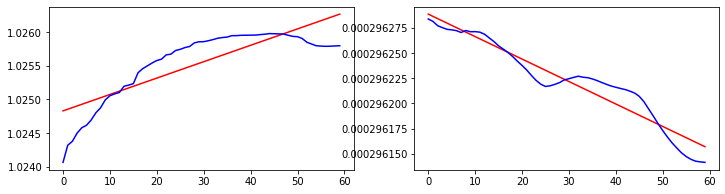

In [110]:
x = [i for i in range(60)]

p_jlsg = np.poly1d((a,b))
y_jlsg = [p_jlsg(i) for i in x]

p_sh = np.poly1d((a_sh, b_sh))
y_sh = [p_sh(i) for i in x]

plt.figure(figsize=(12, 3))
plt.subplot(121)

plt.plot(x, y_jlsg, color='red')
plt.plot(x, ts[40:100], color='blue')

plt.subplot(122)
plt.plot(x, y_sh, color='red')
plt.plot(x, ts_sh[40:100], color='blue')

直观看上去，个股的似乎误差还比较大。但是，这里的纵坐标是相对于开盘价的涨跌幅，所以其实股价的波动是在千分位上的波动，在60分钟的时间里，均价线上涨了约0.2%（从2.4%上涨到2.6%）。因此，该分时线拟合为一条上升的直线，是没有问题的。

注意到个股在尾部出现了下跌的情况，所以，我们需要等待股价上穿均价线，此时作为买入时机。这里我们定义两条曲线相交的函数：

In [111]:
def cross(f, g):
    """
    判断序列f是否与g相交。如果两个序列有且仅有一个交点，则返回1表明f上交g；-1表明f下交g
    returns:
        (flag, index), 其中flag取值为：
        0 无相交
        -1 f向下交叉g
        1 f向上交叉g
    """
    indices = np.argwhere(np.diff(np.sign(f - g))).flatten()

    if len(indices) == 0:
        return 0, 0

    # 如果存在一个或者多个交点，取最后一个
    idx = indices[-1]

    if f[idx] < g[idx]:
        return 1, idx
    elif f[idx] > g[idx]:
        return -1, idx
    else:
        return np.sign(g[idx - 1] - f[idx - 1]), idx

In [112]:
# 这里股价是bars_jlsg['close']，均价线是price(bars_jlsg)
cross(bars_jlsg['close'][40:100], price(bars_jlsg)[40:100])

(1, 56)

结果表明股价曾在位置56处上穿均价线，对应于时间11:06分。我们把这个交点可视化标注出来：

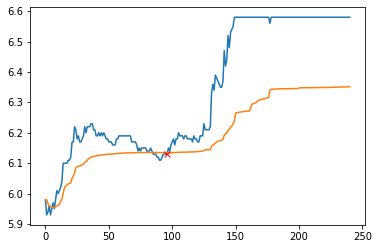

In [113]:
plt.plot(bars_jlsg['close'])
plt.plot(price(bars_jlsg))
plt.plot(96, bars_jlsg['close'][96], 'x', color='red')

图中红叉的地方，就是买入点。如果在这一点您的交易系统发出买入信号，则当天可以赚接近8%，在此后的不到一个月内，股价从7.03元上涨到接近12元，几乎翻倍。而同期上证指先抑后扬，只录得小幅上涨，吉林森工大幅跑赢指数。这样，我们就通过分时寻龙策略，找到了一只潜力股。

??? Tips
    吉林森工现已更名为泉阳泉，主营变更为矿泉水生产和销售。由于主营业务发生变更，它的估值体系也随之发生变化，因此有了补涨的需求。进行生产经营分析是一件十分复杂的事，好在我们可以通过量化策略发现交易信号，而不用去深究其背后的原因。
    一切消息，最终都将反映为价格。

## 结束语

做交易复盘十分重要。这里我们也对本章内容进行一下复盘。

本章我们介绍了如何获取证券列表、概念板块，如何获取个股和指数的k线行情数据。通过本篇内容，您已经了解了，Omicron是大富翁的数据SDK，在使用之前，要通过`await omicron.init`进行初始化，然后获取数据主要是通过Securities和Security两个model类来完成。同时，`omicron.core`还提供了重要的类型定义，这些我们将在第三章陆续介绍。

在文章最后，我们介绍了一个有一定实用性的分时寻龙策略。它的有效性是无庸置疑的，但是，您在使用时，也应该结合当前的大环境，来正确设置不同时间段的收益期望。当整个市场进入系统性下跌过程时，即使是实力的主力，也会提前收兵。

最后我们讨论一下，运行上面的策略，所需要的数据量。

假设我们从开盘后第60分钟起对全市场进行扫描。完成一次扫描，我们需要取得的数据量为：

$$
4000 x 60 = 24(万条)
$$

如果不使用离线缓存的话，我们就要每几分钟就向服务器请求这么大量的数据。显然，这会给服务器带来较大的压力，也使得我们的策略很难实时发出交易信号。此外，如果您使用的数据源有Quota限制的话，这样也很容易用尽Quota。

使用大富翁后，象这样的扫描，已经取得的、已收盘的k线数据都被缓存起来，也就是如果您每分钟运行一次上述策略的话，也只会向服务器请求4000条数据。数据请求量低到之前的$1/60$。

##### **声明：本教程中引用到的股票代码，仅为演示如何使用相关API之目的，并非荐股。相关个股引用期间距现在较远，对当前走势没有任何影响，对您当下的操作没有任何指导意义。下同。**